*Antonio Coín Castro*     


# Bayesian Functional Linear Regression

In [1]:
# -- Libraries

from matplotlib import pyplot as plt
import arviz as az
import numpy as np
import pandas as pd
import pickle
import scipy
from multiprocessing import Pool
import utils

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

We consider the model

$$
Y_i = \alpha_0 + \Psi^{-1}_{X_i}(\alpha) + \varepsilon_i,
$$

i.e.,

$$
Y_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jX_i(t_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)\right]^{-1}\right),
\end{align*}

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \sigma^2)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \sigma^2\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n+2}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \sigma^2\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n+2)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim BM$, a response variable given by a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=1.5$:

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 1.5\big).
$$

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

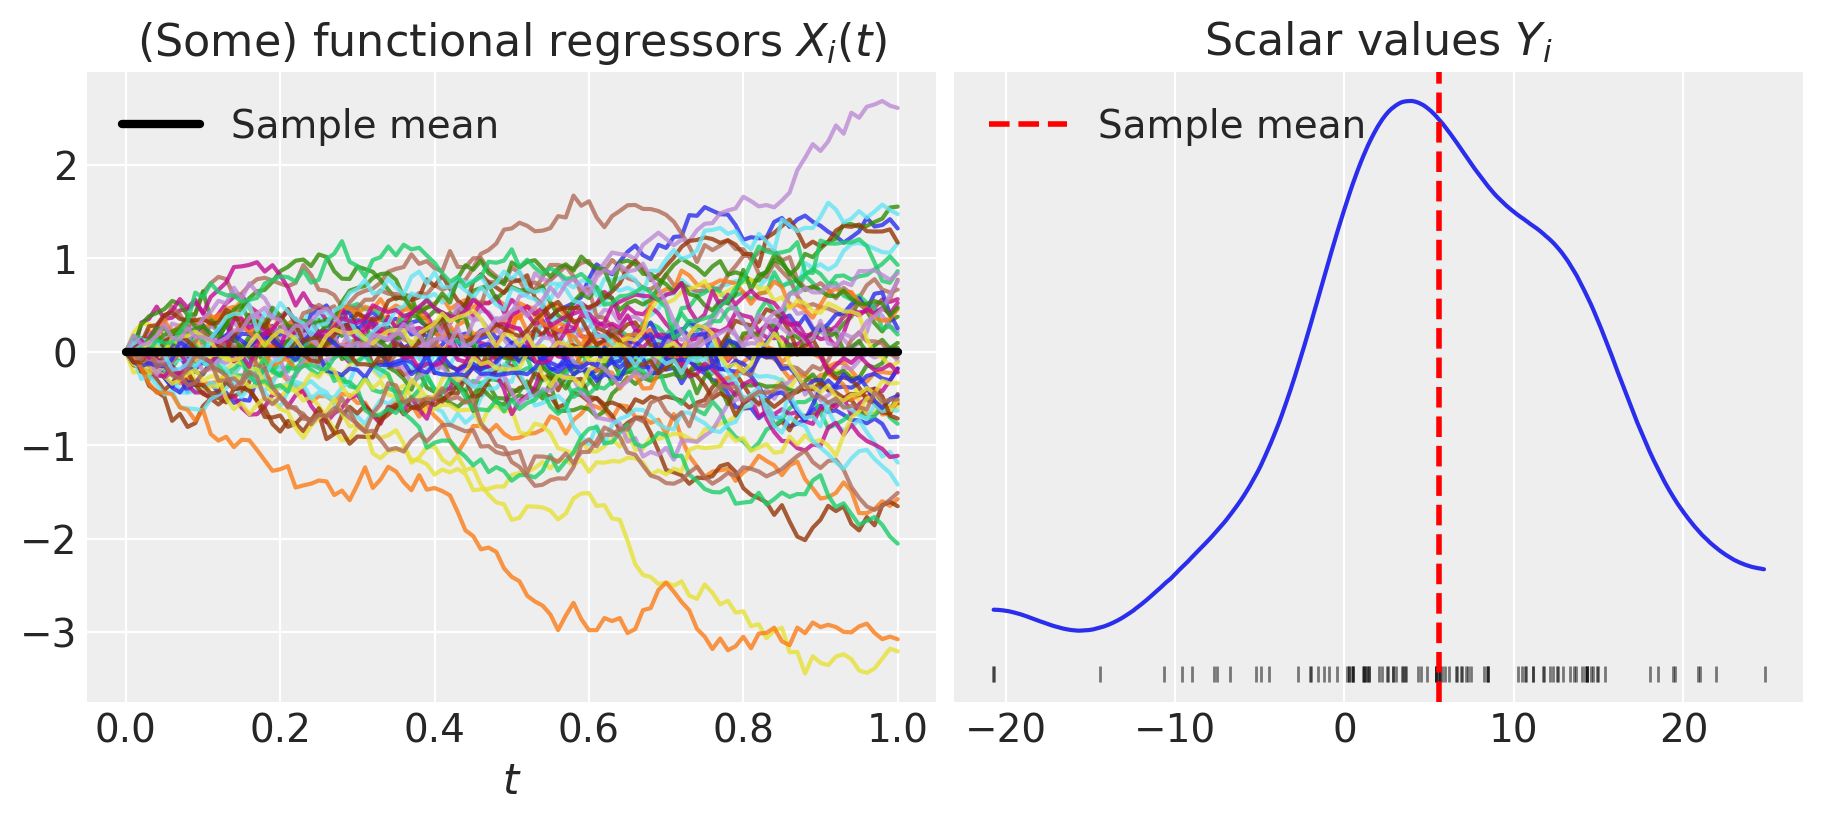

In [3]:
# -- Dataset generation

def brownian_kernel(s, t, sigma=1.0):
    return sigma*np.minimum(s, t)


def ornstein_uhlenbeck_kernel(s, t, l=1.0):
    return np.exp(-np.abs(s - t)/l)


def squared_exponential_kernel(s, t, l=0.2):
    return np.exp(-np.abs(s - t)**2/(2*l**2))


n_train, n_test = 100, 50
N = 101
grid = np.linspace(0., 1., N)

beta_true = np.array([-5., 10.])
tau_true = np.array([0.1, 0.8])
alpha0_true = 5.
sigma2_true = 1.5

theta_true = np.concatenate((
    beta_true, tau_true,
    [alpha0_true], [sigma2_true]
))

X, Y = utils.generate_gp_dataset(
    grid, brownian_kernel,
    n_train, theta_true, rng=rng
)

X_test, Y_test = utils.generate_gp_dataset(
    grid, brownian_kernel,
    n_test, theta_true, rng=rng
)

# Standardize data
X_m = X.mean(axis=0)
X = X - X_m
X_test = X_test - X_m

utils.plot_dataset(X, Y)

## Common model hyperparameters

We will try to recover the true model using $p=3$.

In [4]:
# -- Model hyperparameters

p_hat = 3
g = 5
eta = 0.1
sd_beta_init = 5
sd_alpha0_init = 10*np.abs(Y.mean())  # Grollemund et al (?)
sd_log_sigma_init = 1

In [5]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
theta_names_aux = ["log σ"]

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]

# Individual labels
theta_labels = []
for i in range(p_hat):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"projection": dict(
        zip(np.arange(p_hat), np.arange(1, p_hat + 1)))}
)

# Dimension of parameter vector
theta_ndim = len(theta_labels)

# Dimension of grouped parameter vector
theta_ndim_grouped = len(theta_names)

## Maximum Likelihood Estimator

In [6]:
# -- Negative log-likelihood definition

def neg_ll(theta, X, Y):
    assert len(theta) % 2 == 0

    n, N = X.shape
    grid = np.linspace(0., 1., N)
    p = (len(theta) - 2)//2
    
    beta = theta[:p]
    tau = theta[p:2*p]
    alpha0 = theta[-2]
    log_sigma = theta[-1]
    sigma = np.exp(log_sigma)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]

    return -(-n*log_sigma
             - np.linalg.norm(Y - alpha0 - X_tau@beta)**2/(2*sigma**2))

In [7]:
# -- MLE estimation

# We artificially restrict the variance to a sensible value
bounds = [(None, None)]*p_hat + [(0.0, 1.0)] * \
    p_hat + [(None, None)] + [(None, np.log(2*Y.std()))]

theta_init = utils.initial_guess_random(
    p_hat, sd_beta_init,
    sd_alpha0_init,
    sd_log_sigma_init,
    rng=rng),

mle = scipy.optimize.minimize(
    neg_ll,
    x0=theta_init,
    args=(X, Y),
    bounds=bounds,
)
mle_theta = mle.x
mle_orig = np.copy(mle_theta)
mle_orig[-1] = np.exp(mle_theta[-1])**2  # Transform back to sigma^2

pd.DataFrame(zip(theta_labels, mle_orig),
             columns=["", "MLE"]).style.hide_index()

## The Ensemble Sampler and the *emcee* library

In [8]:
import emcee

### Model

We only need to provide the sampler with the logarithm of the posterior distribution. For clarity we split up its computation in log-prior and log-likelihood, although for a more efficient implementation it should all be in one function. 

In [9]:
# -- Log-posterior model

def log_prior(theta):
    """Global parameters (for efficient parallelization): X, b0, g, eta"""
    assert len(theta) % 2 == 0
    
    n, N = X.shape
    p = (len(theta) - 2)//2
    grid = np.linspace(0., 1., N)
    
    beta = theta[:p]
    tau = theta[p:2*p]
    alpha0 = theta[-2]
    log_sigma = theta[-1]

    # Transform variables
    b = beta - b0
    sigma = np.exp(log_sigma)

    # Impose constraints on parameters
    if (tau < 0.0).any() or (tau > 1.0).any():
        return -np.inf

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 - (p + 2)*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma**2))

    return log_prior


def log_likelihood(theta, Y):
    """Global parameters (for efficient parallelization): X"""
    return -neg_ll(theta, X, Y)


def log_posterior(theta, Y):
    """Global parameters (for efficient parallelization): X, rng, return_pps"""
    lp = log_prior(theta)

    if not np.isfinite(lp):
        if return_pps:
            return -np.inf, np.full_like(Y, -np.inf)
        else:
            return -np.inf

    ll = log_likelihood(theta, Y)
    lpos = lp + ll

    if return_pps:
        theta_orig = np.copy(theta)
        theta_orig[-1] = np.exp(theta_orig[-1])**2
        pps = utils.generate_response(X, theta_orig, rng=rng)
        return lpos, pps
    else:
        return lpos

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [10]:
# -- Sampler parameters

n_walkers = 100
n_iter_initial = 500
n_iter = 1000
return_pps = True

# Start every walker in a (random) neighbourhood around the MLE
p0 = utils.intial_guess_around_value(
    mle_theta, n_walkers=n_walkers, rng=rng)

b0 = mle_theta[:p_hat]  # <-- Change if needed

In [11]:
# -- Run sampler

with Pool(N_CORES) as pool:
    print(
        f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

    sampler = emcee.EnsembleSampler(
        n_walkers, theta_ndim, log_posterior, pool=pool, args=(Y,))

    print("Tuning phase...")
    state = sampler.run_mcmc(
        p0, n_iter_initial, progress='notebook',
        store=False)
    sampler.reset()

    print("MCMC sampling...")
    sampler.run_mcmc(state, n_iter, progress='notebook')

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/500 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [12]:
# -- Sampler statistics and trace

# Analyze autocorrelation and set burn-in and thinning values
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
burn = int(3*max_autocorr)
thin = 1

# Get trace of samples
trace = np.copy(sampler.get_chain(discard=burn, thin=thin))
trace[:, :, -1] = np.exp(trace[:, :, -1])**2  # Recover sigma^2
trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

# Get InferenceData object
idata_emcee = utils.emcee_to_idata(
    sampler, p_hat, theta_names, theta_names_aux, 
    burn, thin, return_pps)

# Update and show autocorrelation
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)
print(
    f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")
pd.DataFrame(
    zip(theta_labels, autocorr_thin, len(trace_flat)/autocorr_thin),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [67.714 68.628 72.879 78.37  77.191 73.443 70.843 67.105]
The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 15;
tau: [59.086 57.921 64.598 60.99  67.033 61.317 57.384 60.046]


Mean acceptance fraction: 30.541%


In [13]:
utils.summary(idata_emcee, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%    mode
β[1]        9.996  0.187   9.666   10.331  10.007
β[2]       -4.489  0.392  -5.209   -3.739  -4.494
β[3]        0.317  0.507  -0.643    1.240   0.258
τ[1]        0.800  0.003   0.795    0.804   0.796
τ[2]        0.100  0.003   0.095    0.104   0.095
τ[3]        0.296  0.255   0.000    0.827   0.001
$\alpha_0$  5.586  0.120   5.349    5.808   5.610
$\sigma^2$  1.368  0.192   1.018    1.732   1.319

Combined density and trace plot:


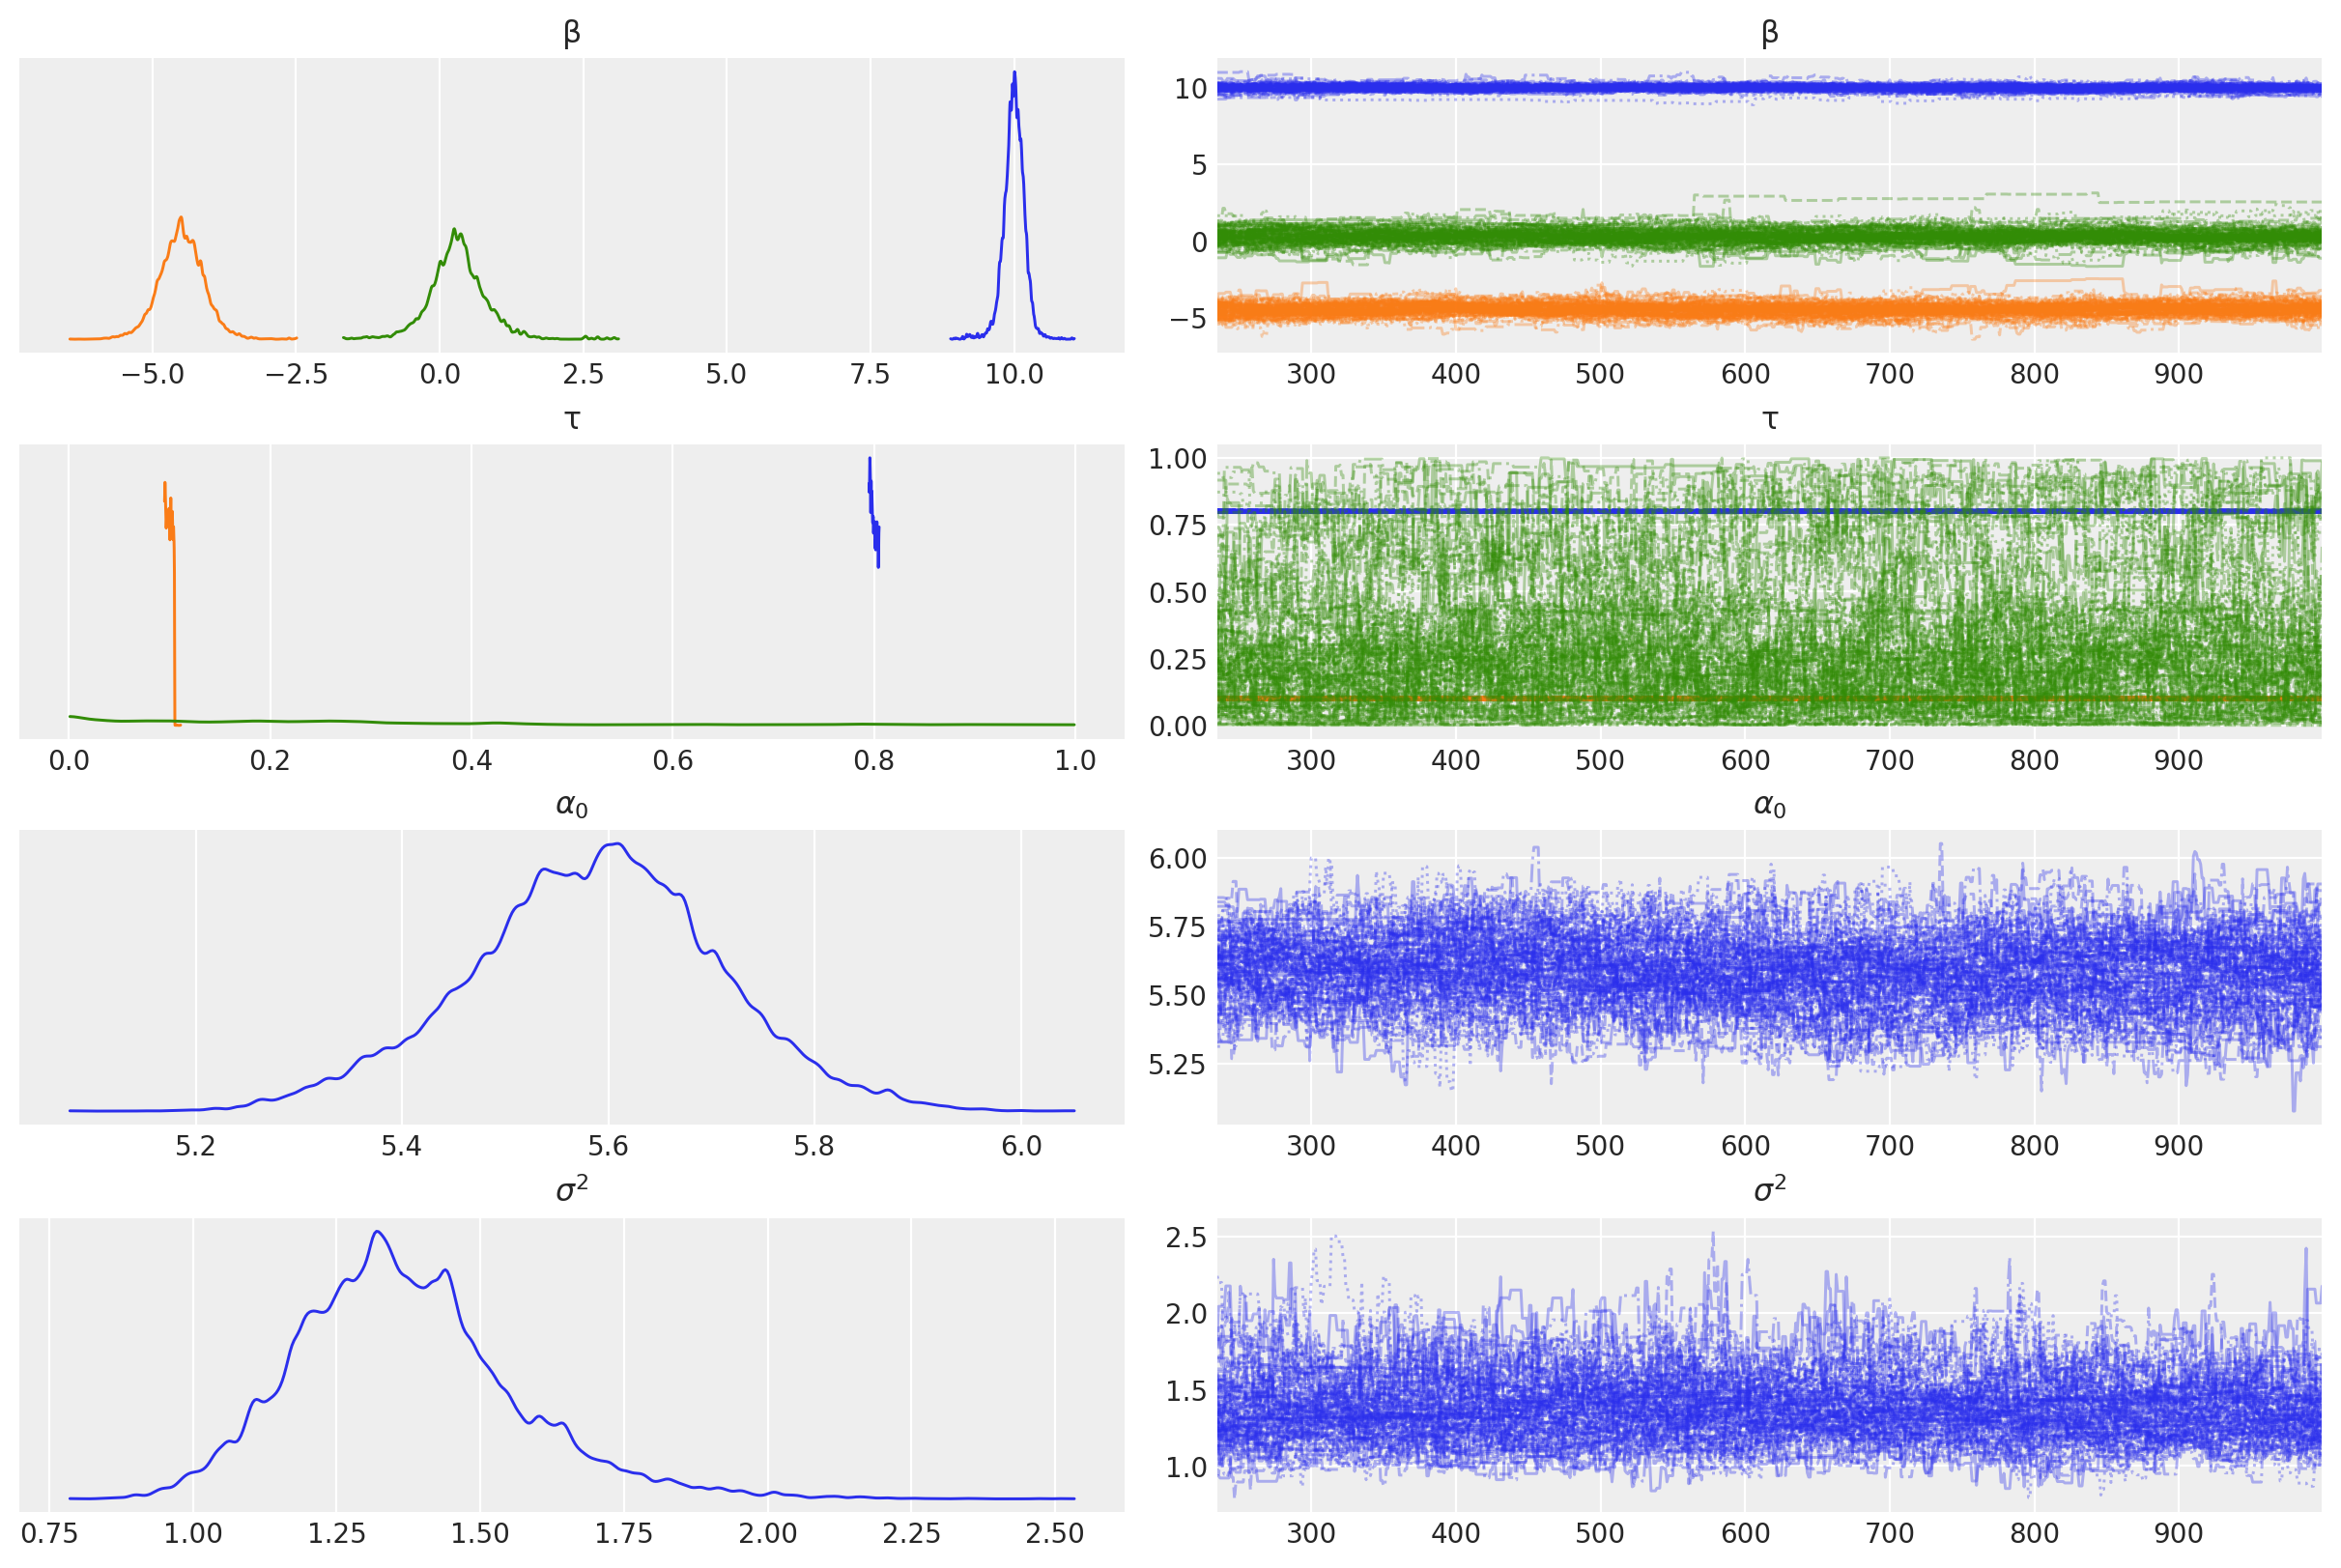

In [14]:
az.plot_trace(idata_emcee, labeller=theta_labeller,
                    combined=True, var_names=theta_names)
print("Combined density and trace plot:")

Marginal posterior distributions:


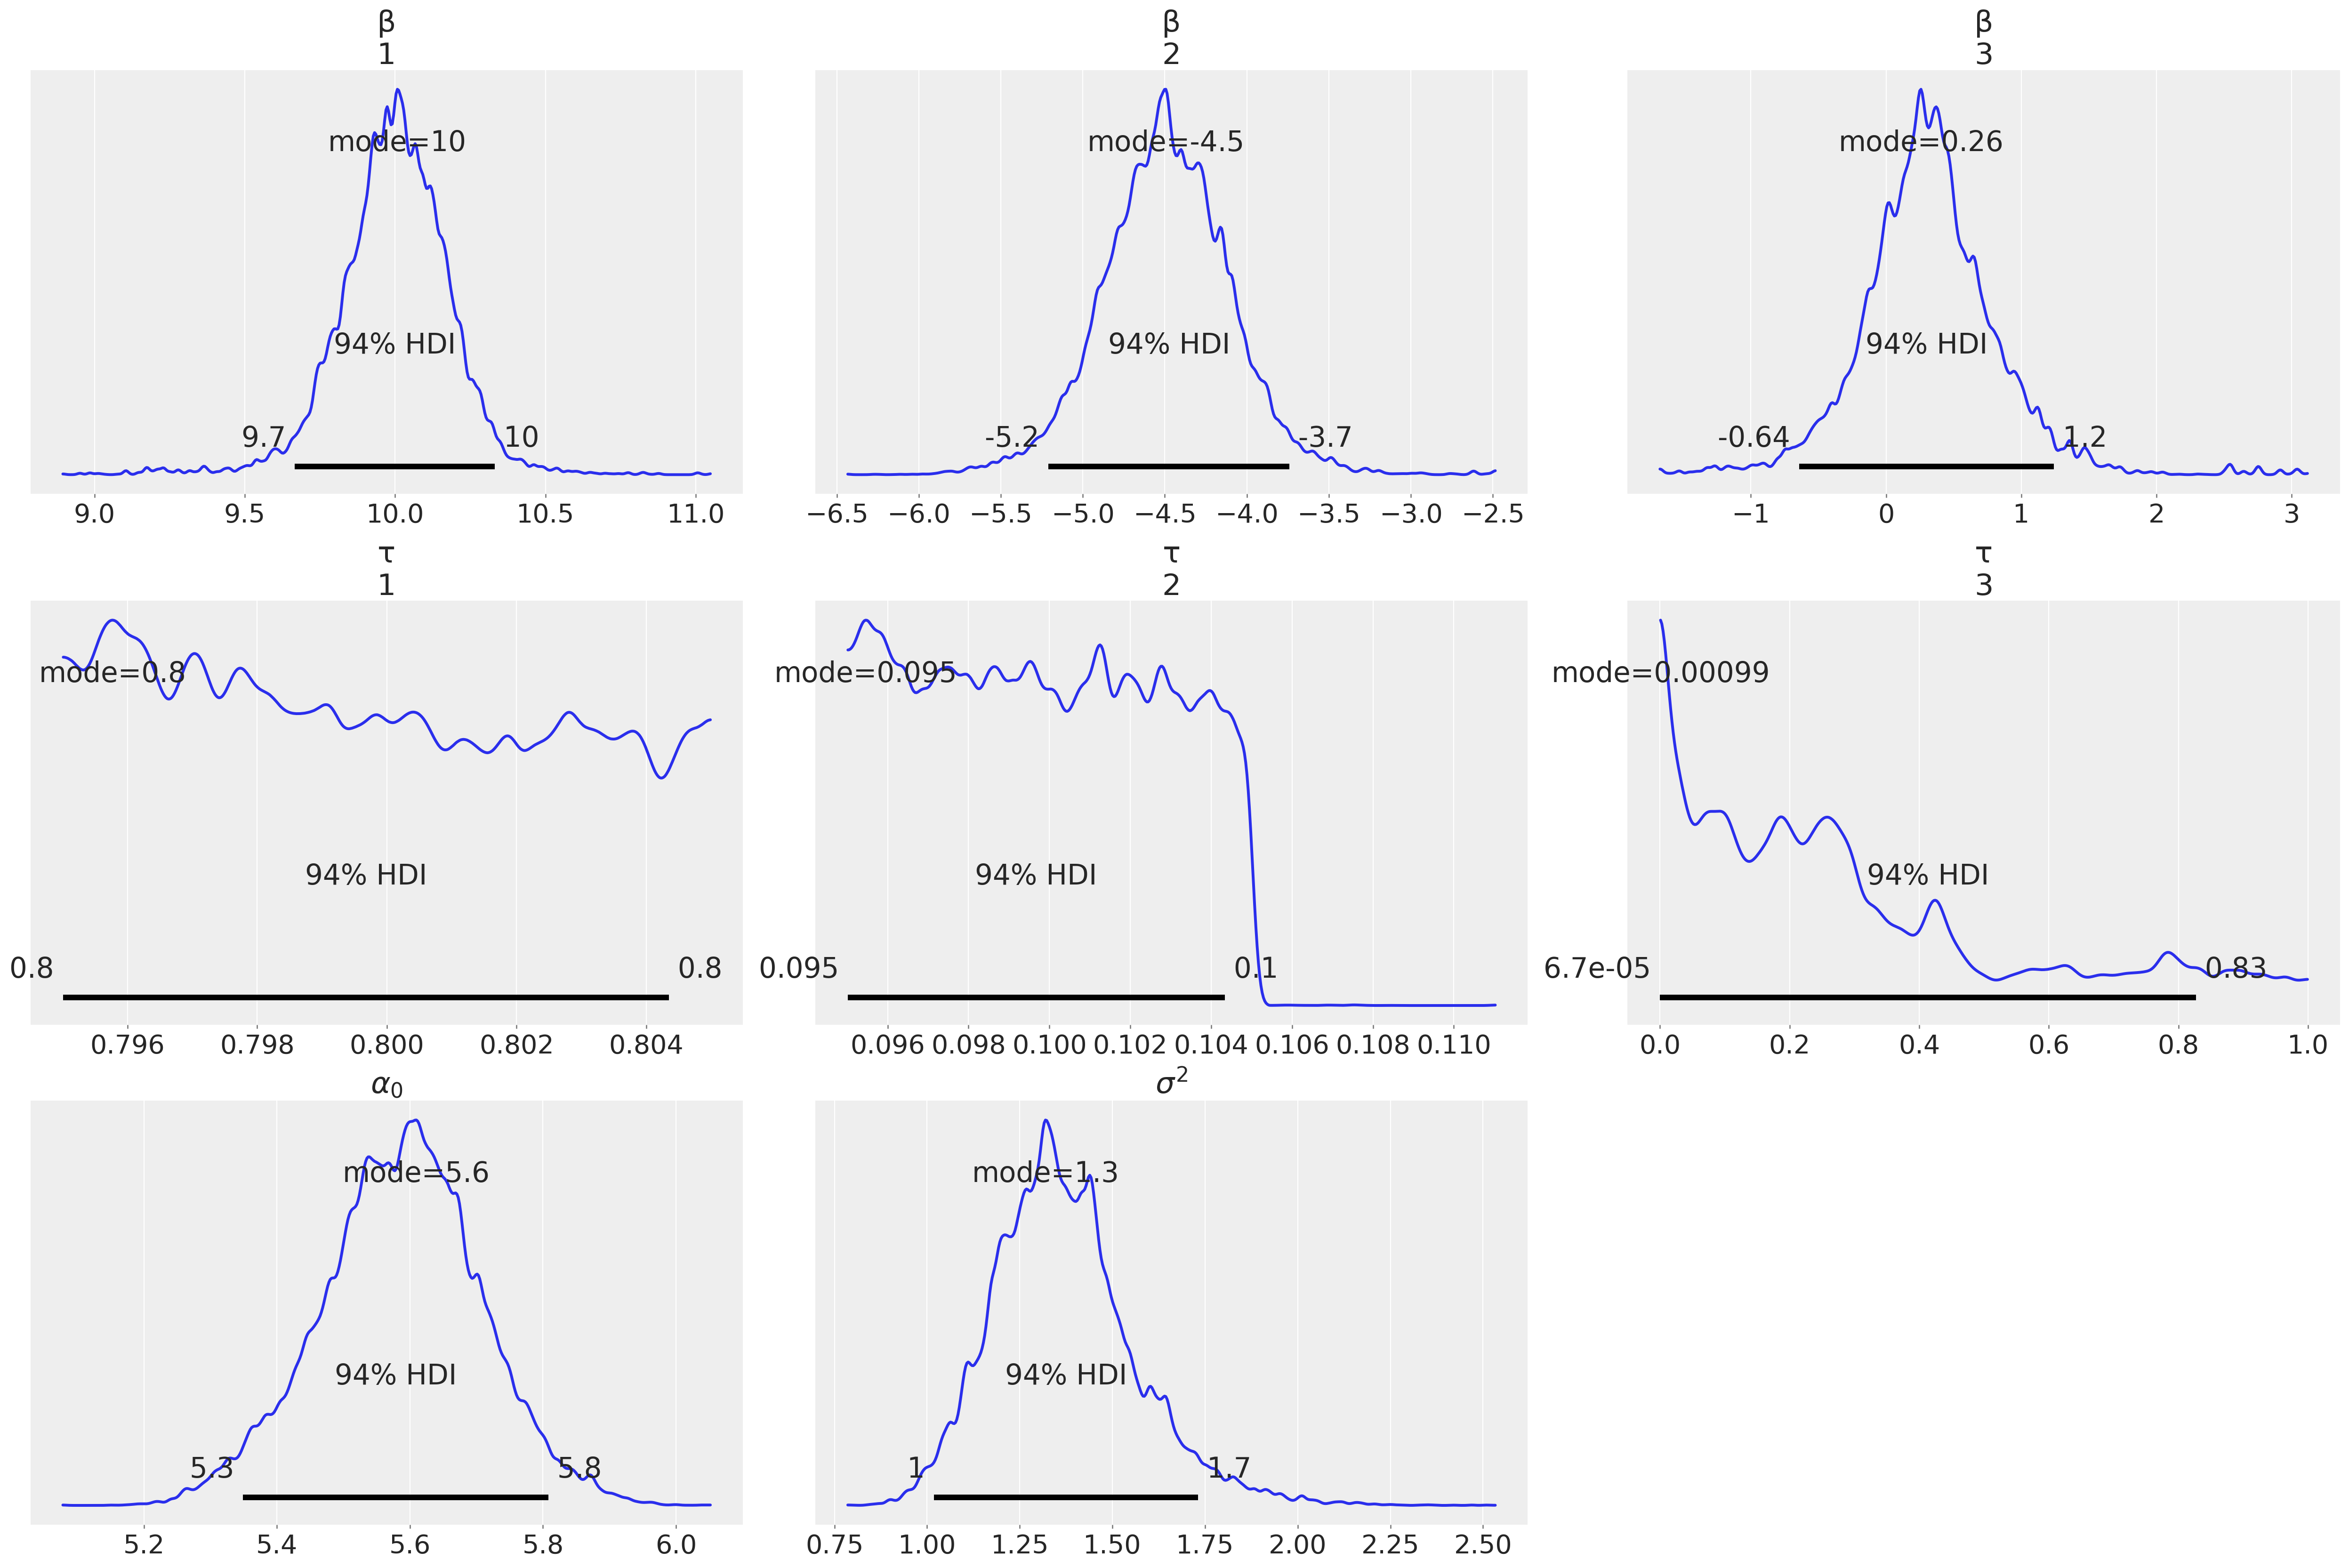

In [15]:
az.plot_posterior(idata_emcee, labeller=theta_labeller, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20,
                  var_names=theta_names)
print("Marginal posterior distributions:")

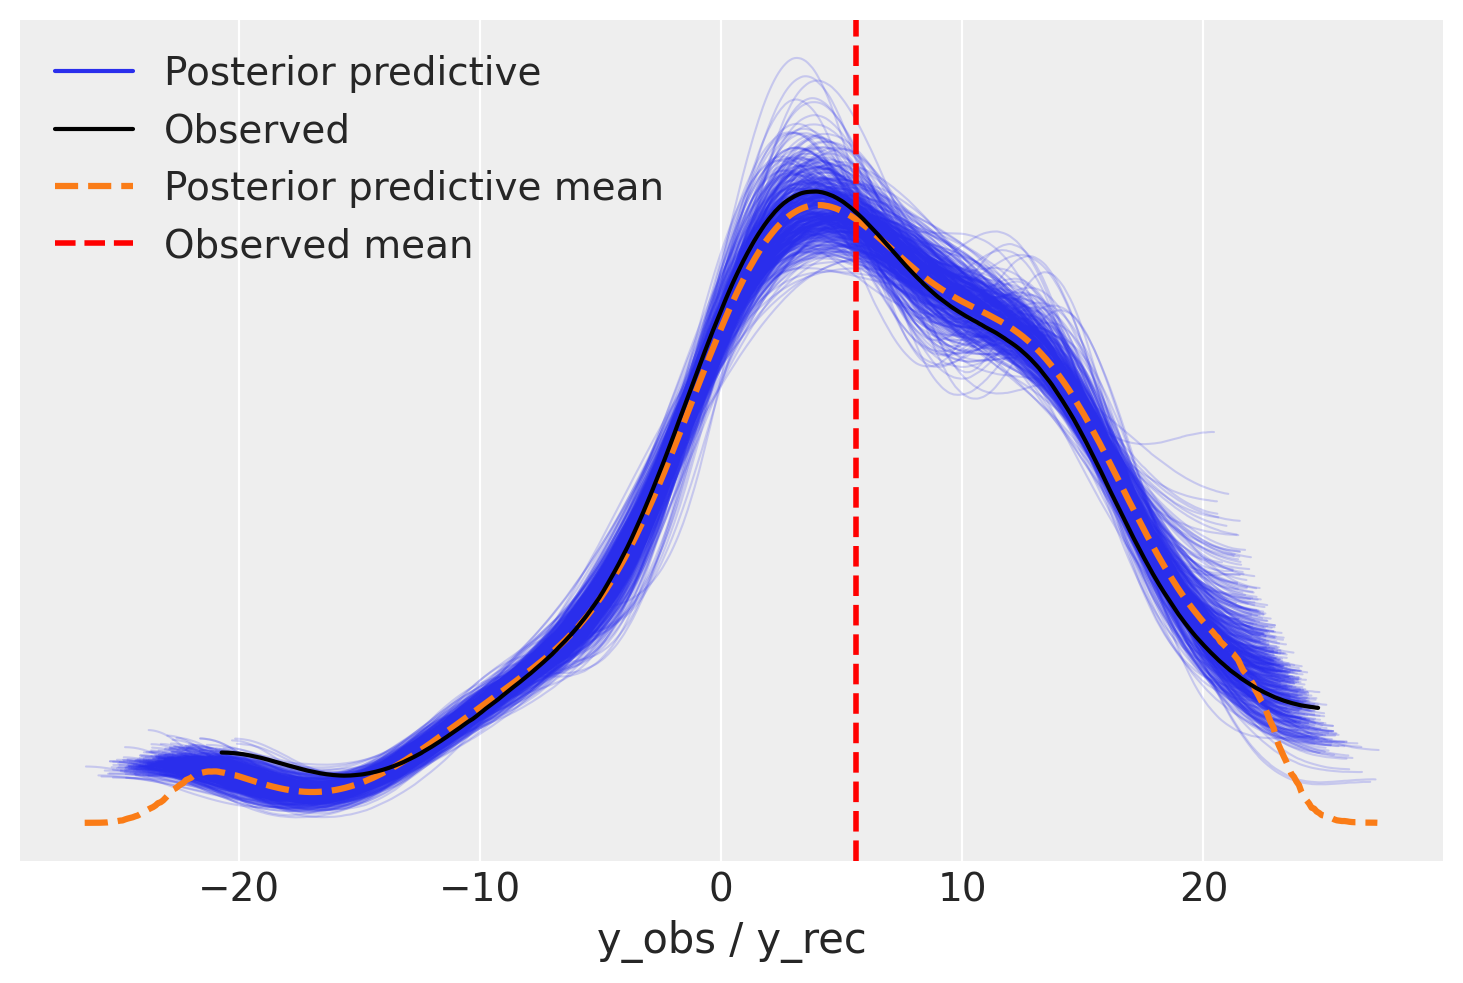

In [16]:
# -- Generate and plot posterior predictive samples from X

if "posterior_predictive" not in idata_emcee:
    ppc = utils.generate_ppc(idata_emcee, X, theta_names, rng=rng)
    idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_rec")
else:
    idata_ppc = idata_emcee

utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={'y_obs': 'y_rec'})

Combined autocorrelation times:


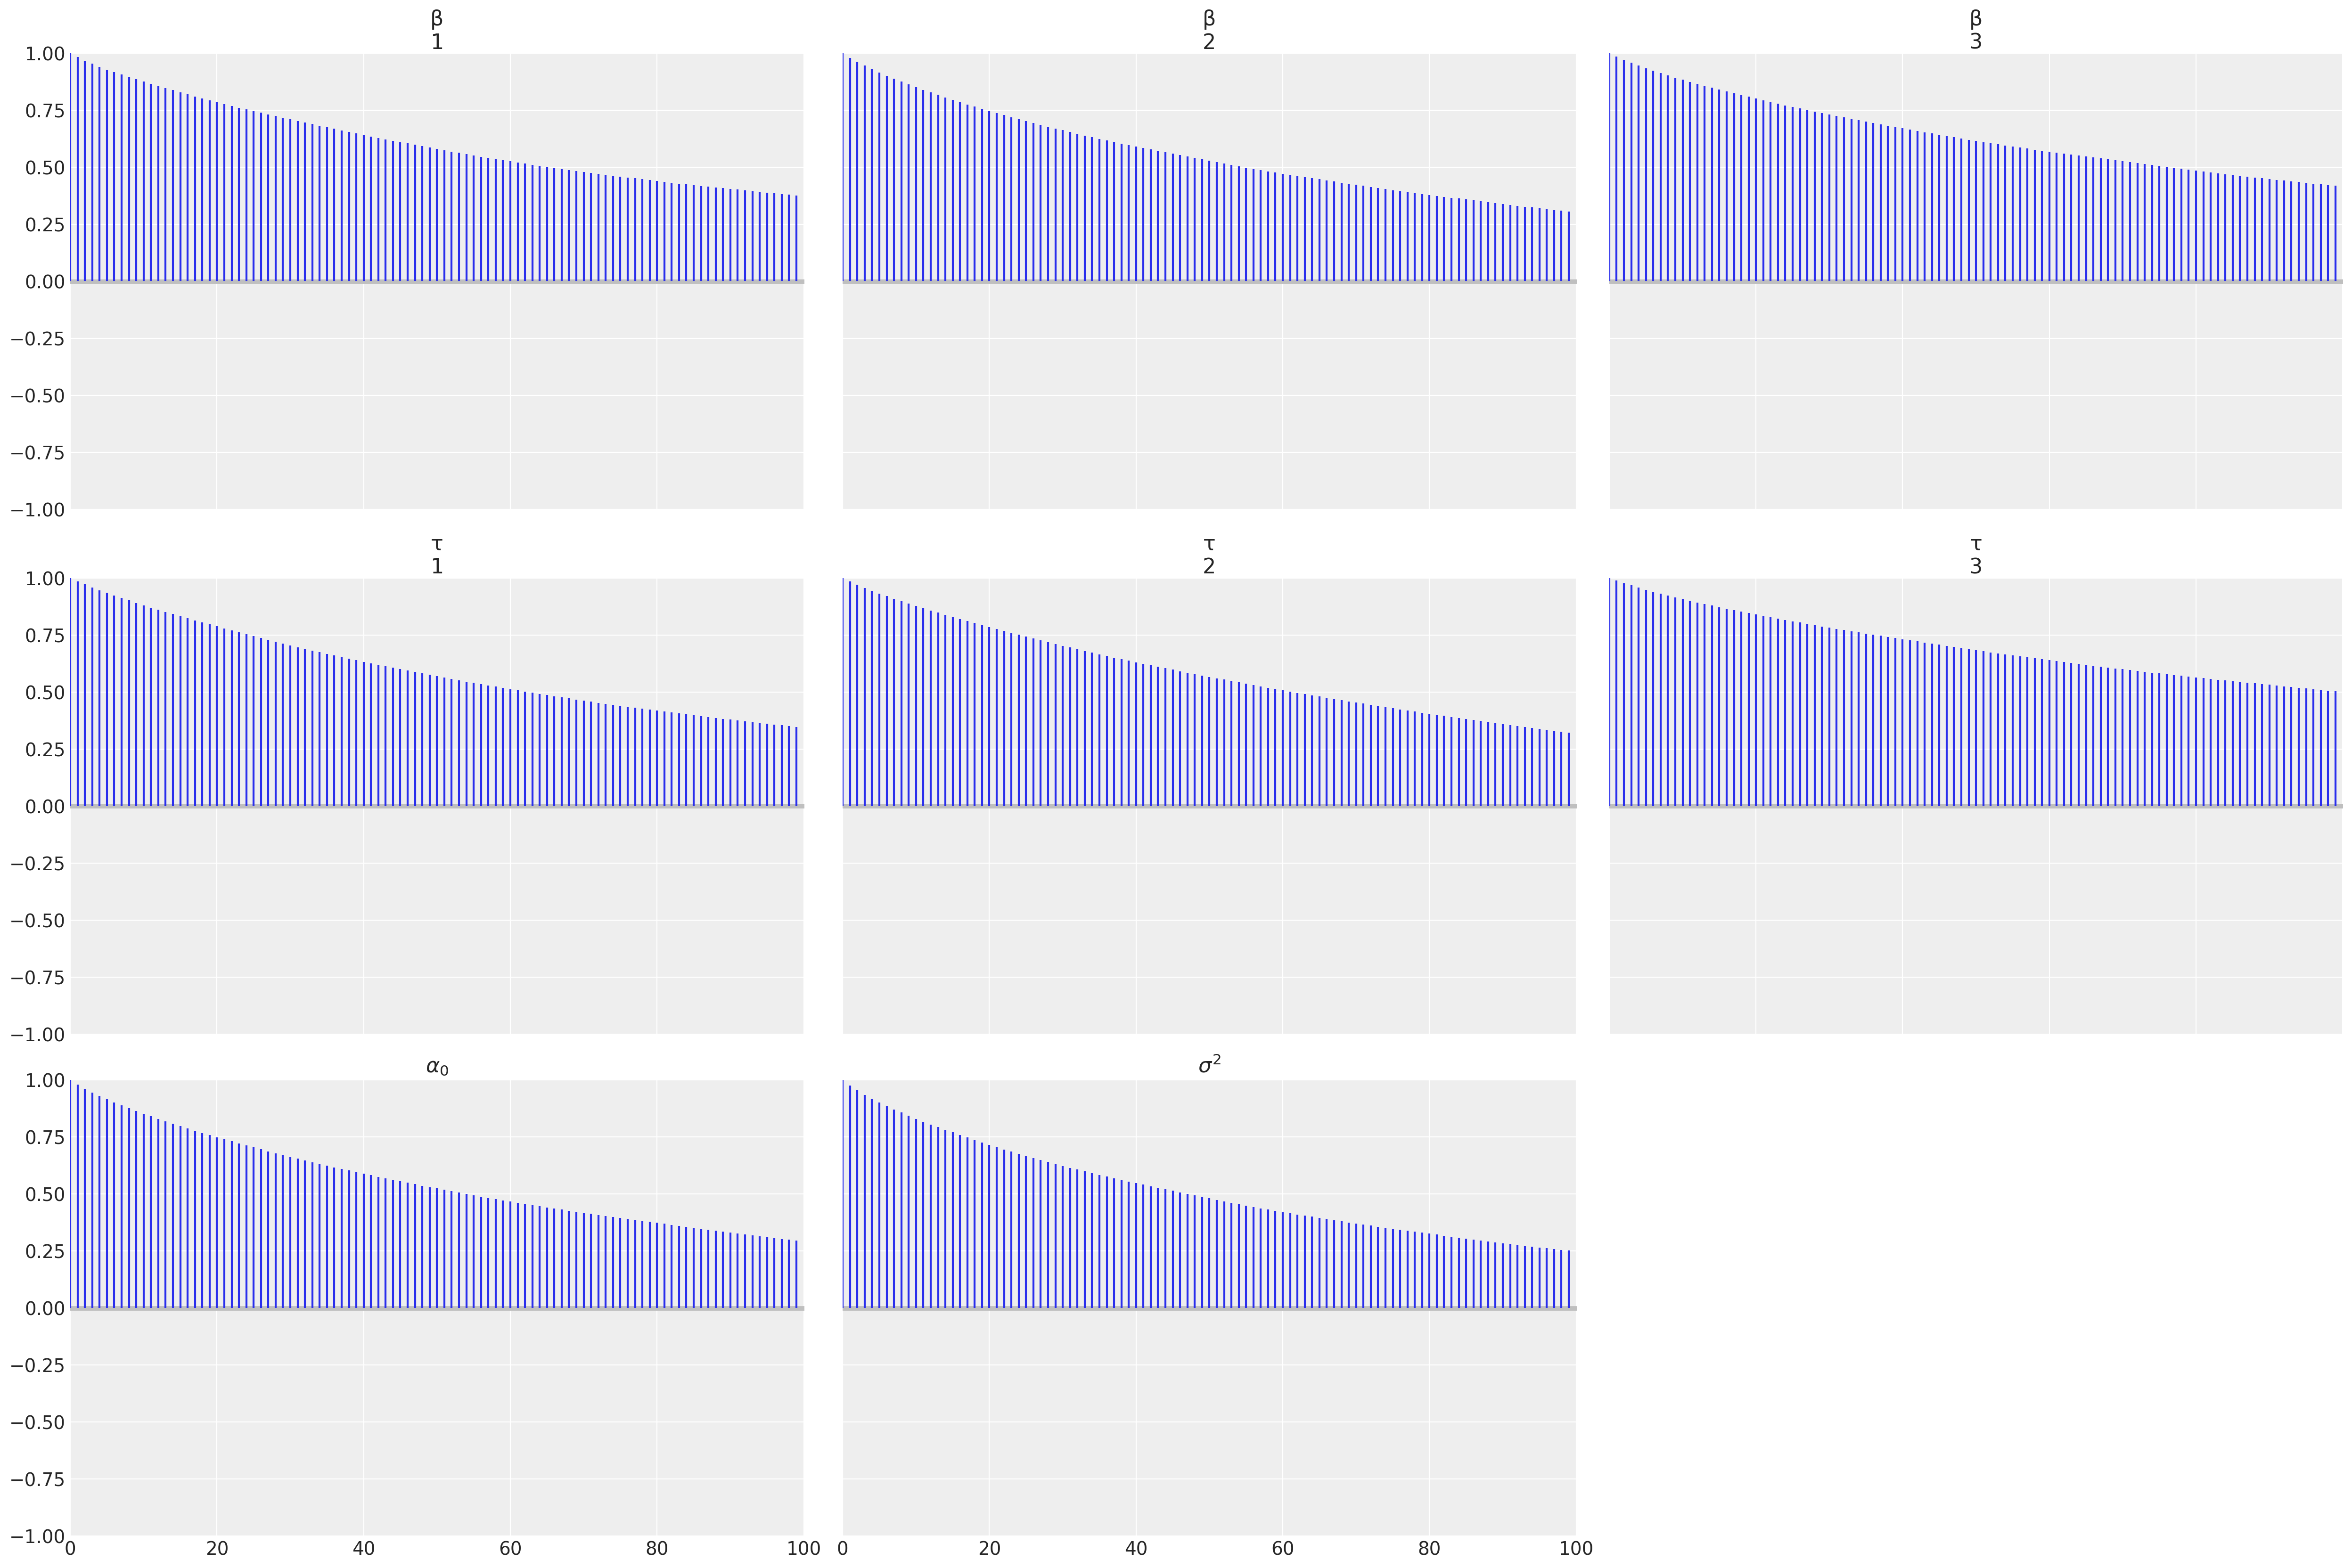

In [17]:
az.plot_autocorr(idata_emcee, combined=True, var_names=theta_names,
                 grid=(NROWS(theta_ndim), NCOLS), labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

Posterior predictive samples:   0%|          | 0/100 [00:00<?, ?it/s]

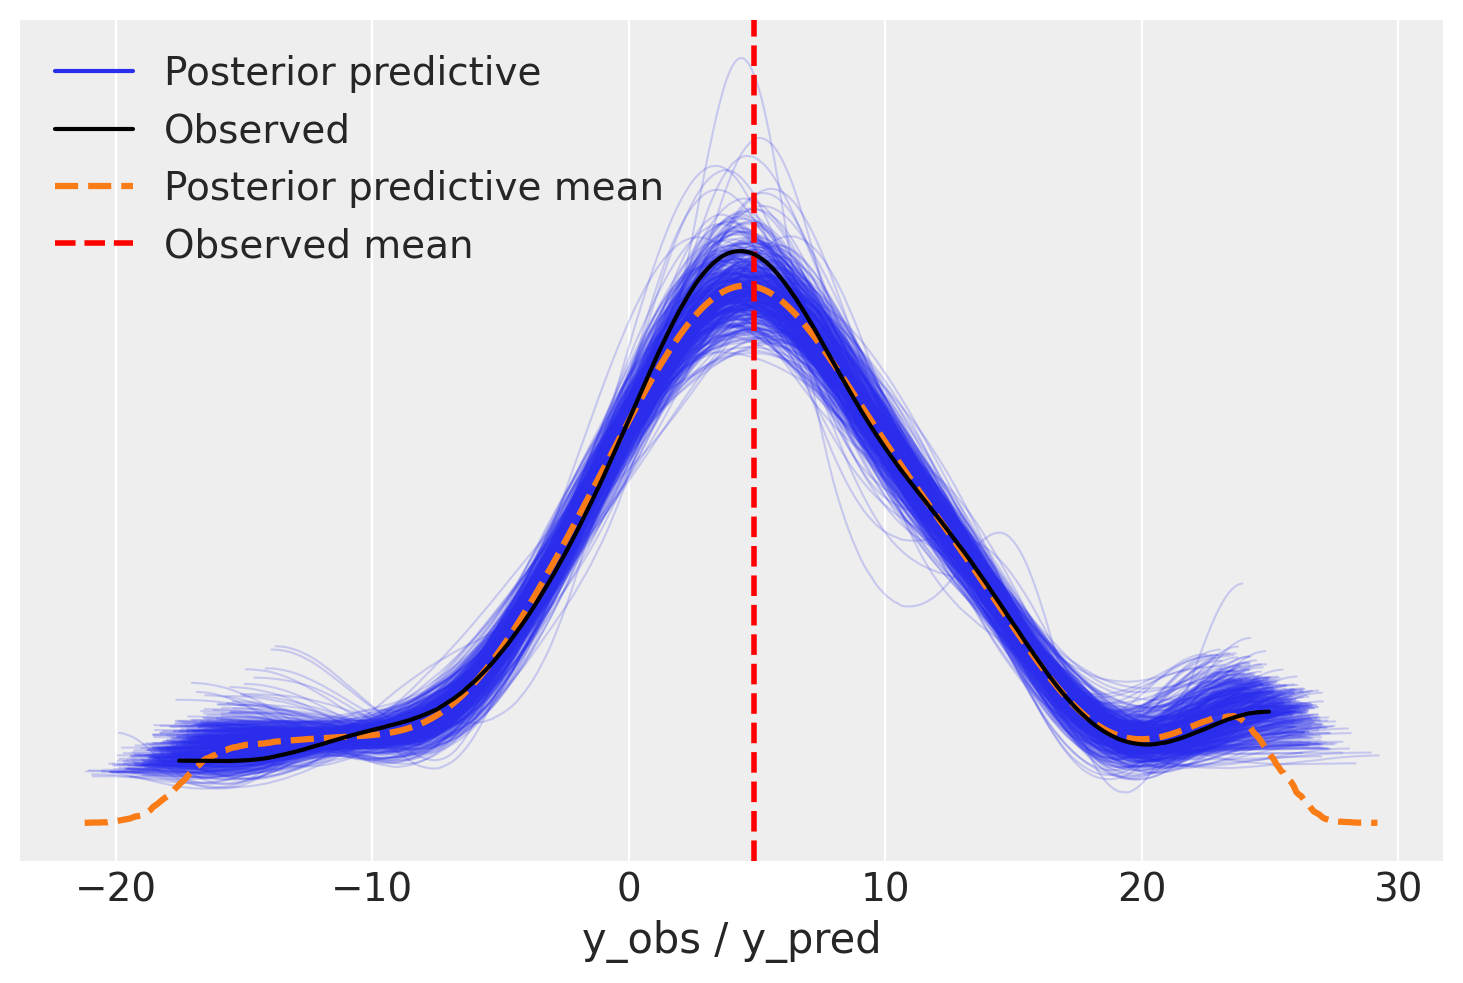

In [18]:
# -- Generate and plot posterior predictive samples from X_test

ppc = utils.generate_ppc(idata_emcee, X_test, theta_names, rng=rng)
idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_pred", y_obs=Y_test)

utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={'y_obs': 'y_pred'})

In [19]:
# -- Compute MSE using several point estimates

point_estimates = ["mode", "mean", "median"]

df_mse_emcee = pd.DataFrame(columns=["", "MSE"])

for pe in point_estimates:
    Y_hat = utils.point_predict(X_test, idata_emcee,
                                theta_names, point_estimate=pe, 
                                rng=rng)
    mse = utils.mse(Y_test, Y_hat)
    df_mse_emcee.loc[pe] = [pe, mse]

df_mse_emcee.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [19]:
with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [37]:
with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [77]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

We set the value of $b_0$ as the MLE for $\beta$.

In [81]:
def make_model(p, g, eta, X, Y, names, init_MLE=True):
    n, N = X.shape
    grid = np.linspace(0., 1., N)
    
    if init_MLE:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)
        Y_pm = pm.Data('Y', Y)

        alpha0_and_log_sigma = pm.DensityDist(
            'alpha0_and_log_sigma', lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        expected_obs = alpha0 + pm.math.matrix_dot(X_tau, beta)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y_pm)

    return model

### Experiments

In [82]:
# NUTS with MLE as starting point
model_MLE = make_model(p_hat, g, eta, X, Y, theta_names)

with model_MLE:
    print("Starting from MLE...")
    ttr = model_MLE.named_vars[theta_names[1]].transformation
    start = {"beta": mle_theta[:p_hat],
             "tau_interval__": ttr.forward(mle_theta[p_hat:2*p_hat]).eval(),
             "alpha0_and_log_sigma": mle_theta[-2:]}
    idata_mle = pm.sample(1000, cores=2, tune=1000, start=start,
                          target_accept=0.8, return_inferencedata=True)
    
    # TODO: return_inferencedata=False and utils.from_pymc(....) to
    # set names correctly

Starting from MLE...


KeyError: 'tau'

In [185]:
utils.summary(idata_mle, theta_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  9.560  0.397   8.737   10.086      0.120    0.087      19.0   
beta[1] -3.234  0.645  -4.203   -1.701      0.183    0.133      20.0   
beta[2] -0.160  0.933  -1.899    1.328      0.330    0.242       8.0   
tau[0]   0.800  0.003   0.796    0.805      0.000    0.000     166.0   
tau[1]   0.101  0.005   0.095    0.112      0.001    0.000      99.0   
tau[2]   0.355  0.328   0.000    0.851      0.068    0.053      49.0   
alpha0   5.409  0.132   5.158    5.646      0.009    0.006     229.0   
sigma2   1.841  0.278   1.429    2.423      0.028    0.020     102.0   

         ess_tail  r_hat   mode  
beta[0]      40.0   1.08  9.769  
beta[1]      18.0   1.10 -3.368  
beta[2]      50.0   1.20  0.238  
tau[0]      560.0   1.00  0.805  
tau[1]       64.0   1.03  0.096  
tau[2]      116.0   1.10  0.001  
alpha0      253.0   1.00  5.408  
sigma2      260.0   1.03  1.720

In [25]:
# NUTS with MAP as starting point
model_MAP = make_model(p_hat, g, eta, X, Y, grid)

with model_MAP:
    print("Computing MAP estimate...")
    start = pm.find_MAP()
    print("Starting from MAP estimate...")
    idata_map = pm.sample(1000, cores=2, tune=1000, start=start,
                          target_accept=0.8, return_inferencedata=True)

Computing MAP estimate...



Starting from MAP estimate...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau, mu_and_log_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
utils.summary(idata_map, theta_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  10.009  0.148   9.707   10.264      0.007    0.005     396.0   
beta[1]  -4.546  0.322  -5.157   -3.960      0.023    0.017     195.0   
beta[2]   0.202  0.342  -0.482    0.806      0.023    0.016     233.0   
tau[0]    0.800  0.003   0.796    0.805      0.000    0.000     253.0   
tau[1]    0.100  0.003   0.095    0.104      0.000    0.000     225.0   
tau[2]    0.273  0.231   0.000    0.760      0.012    0.008     339.0   
mu        5.601  0.089   5.435    5.766      0.005    0.003     339.0   
sigma2    0.925  0.132   0.686    1.170      0.008    0.006     252.0   

         ess_tail  r_hat    mode  
beta[0]     464.0   1.01  10.017  
beta[1]     230.0   1.01  -4.555  
beta[2]     293.0   1.01   0.192  
tau[0]      676.0   1.01   0.805  
tau[1]      802.0   1.00   0.097  
tau[2]      379.0   1.00   0.001  
mu          512.0   1.00   5.592  
sigma2      559.0   1.02   0.884

In [83]:
# NUTS with auto initialization
model_auto = make_model(p_hat, g, eta, X, Y, theta_names)

with model_auto:
    idata_auto = pm.sample(1000, cores=2, tune=1000, target_accept=0.8,
                           return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, τ, alpha0_and_log_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [86]:
utils.summary(idata_auto, var_names=theta_names, labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]        9.985  0.216   9.620   10.332      0.016    0.011     279.0   
β[1]       -4.532  0.382  -5.321   -3.838      0.024    0.017     269.0   
β[2]        0.323  0.449  -0.493    1.246      0.039    0.028     131.0   
τ[0]        0.800  0.003   0.795    0.805      0.000    0.000     230.0   
τ[1]        0.100  0.003   0.095    0.104      0.000    0.000     323.0   
τ[2]        0.292  0.254   0.000    0.822      0.019    0.013     176.0   
$\alpha_0$  5.576  0.119   5.360    5.795      0.006    0.004     365.0   
$\sigma^2$  1.373  0.196   1.048    1.774      0.010    0.007     400.0   

            ess_tail  r_hat    mode  
β[0]           185.0   1.02  10.001  
β[1]           230.0   1.01  -4.509  
β[2]           233.0   1.03   0.297  
τ[0]           812.0   1.02   0.802  
τ[1]          1020.0   1.02   0.103  
τ[2]           201.0   1.00   0.001  
$\alpha_0$     685.0   1.01   5.588  
$\sigma^2$     663.0   1.01   1.296

### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

Graphical model:


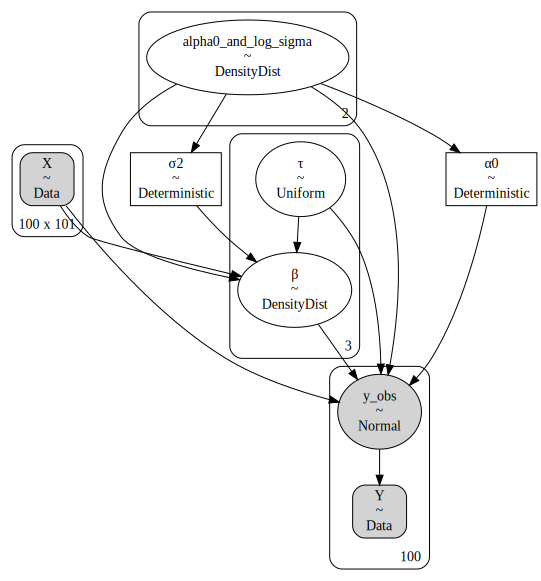

In [88]:
# Select and print best model
burn = 0
thin = 1

model = model_auto
idata_pymc = idata_auto
idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

Trace plot:


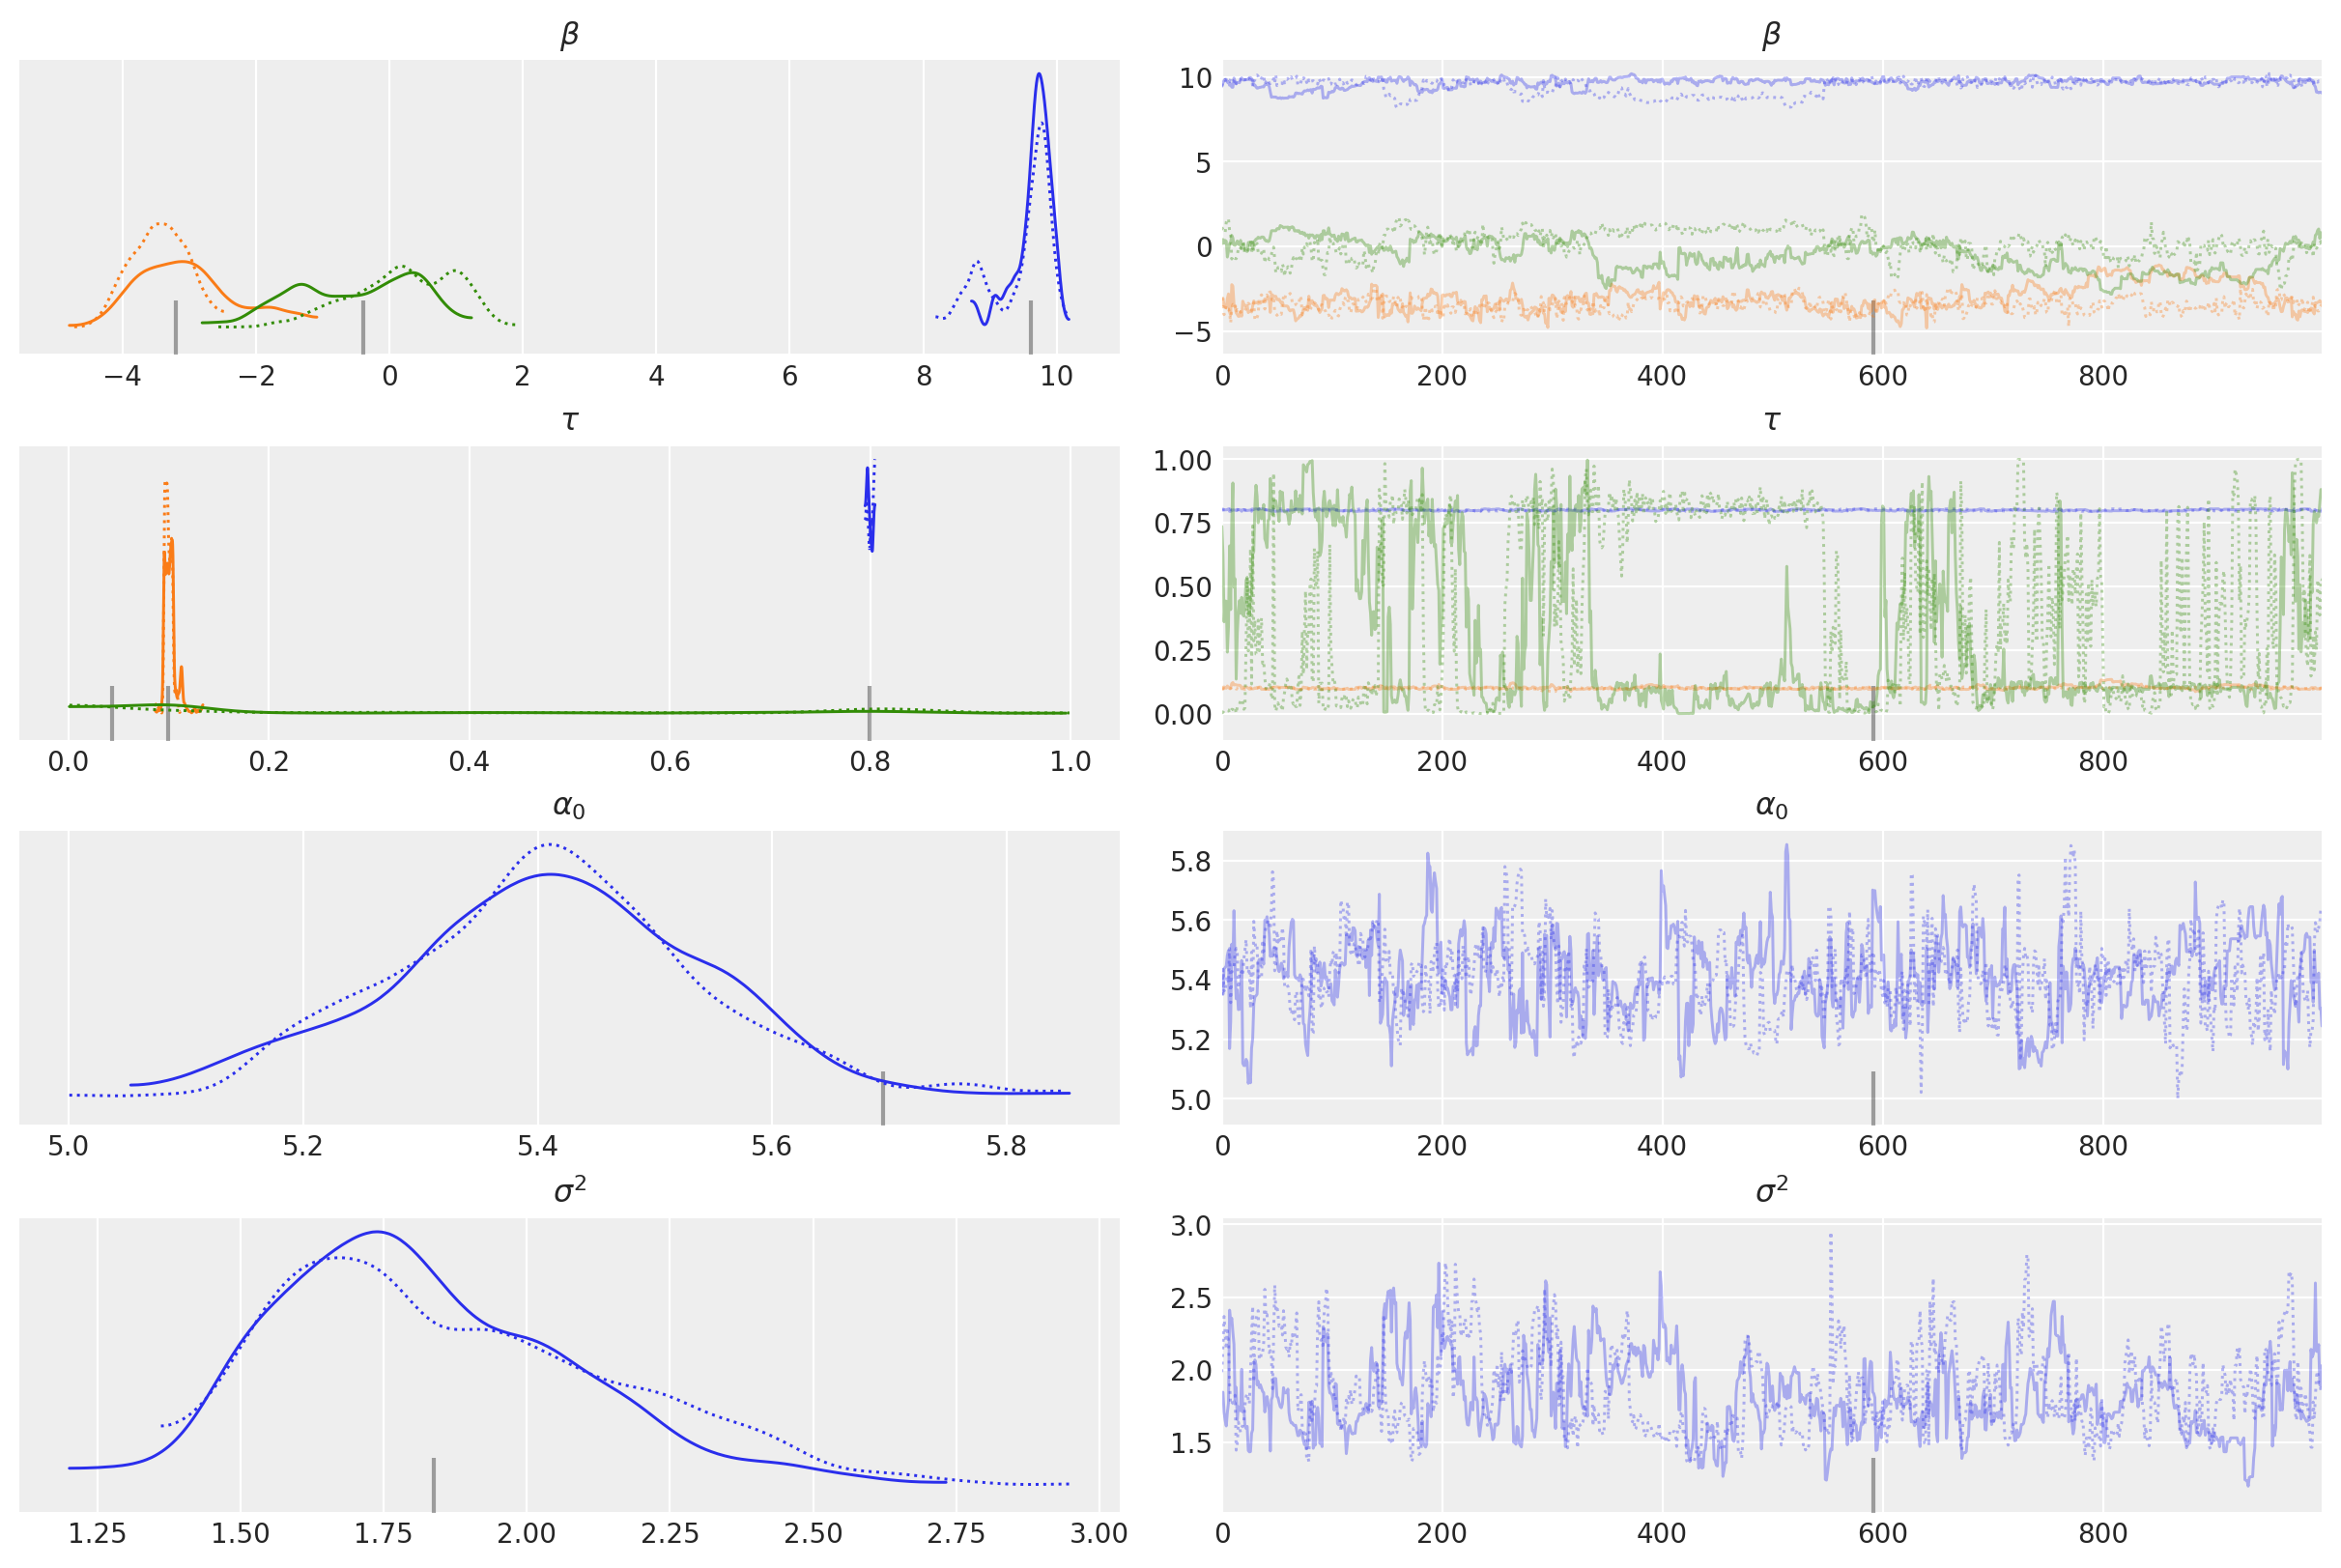

In [187]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


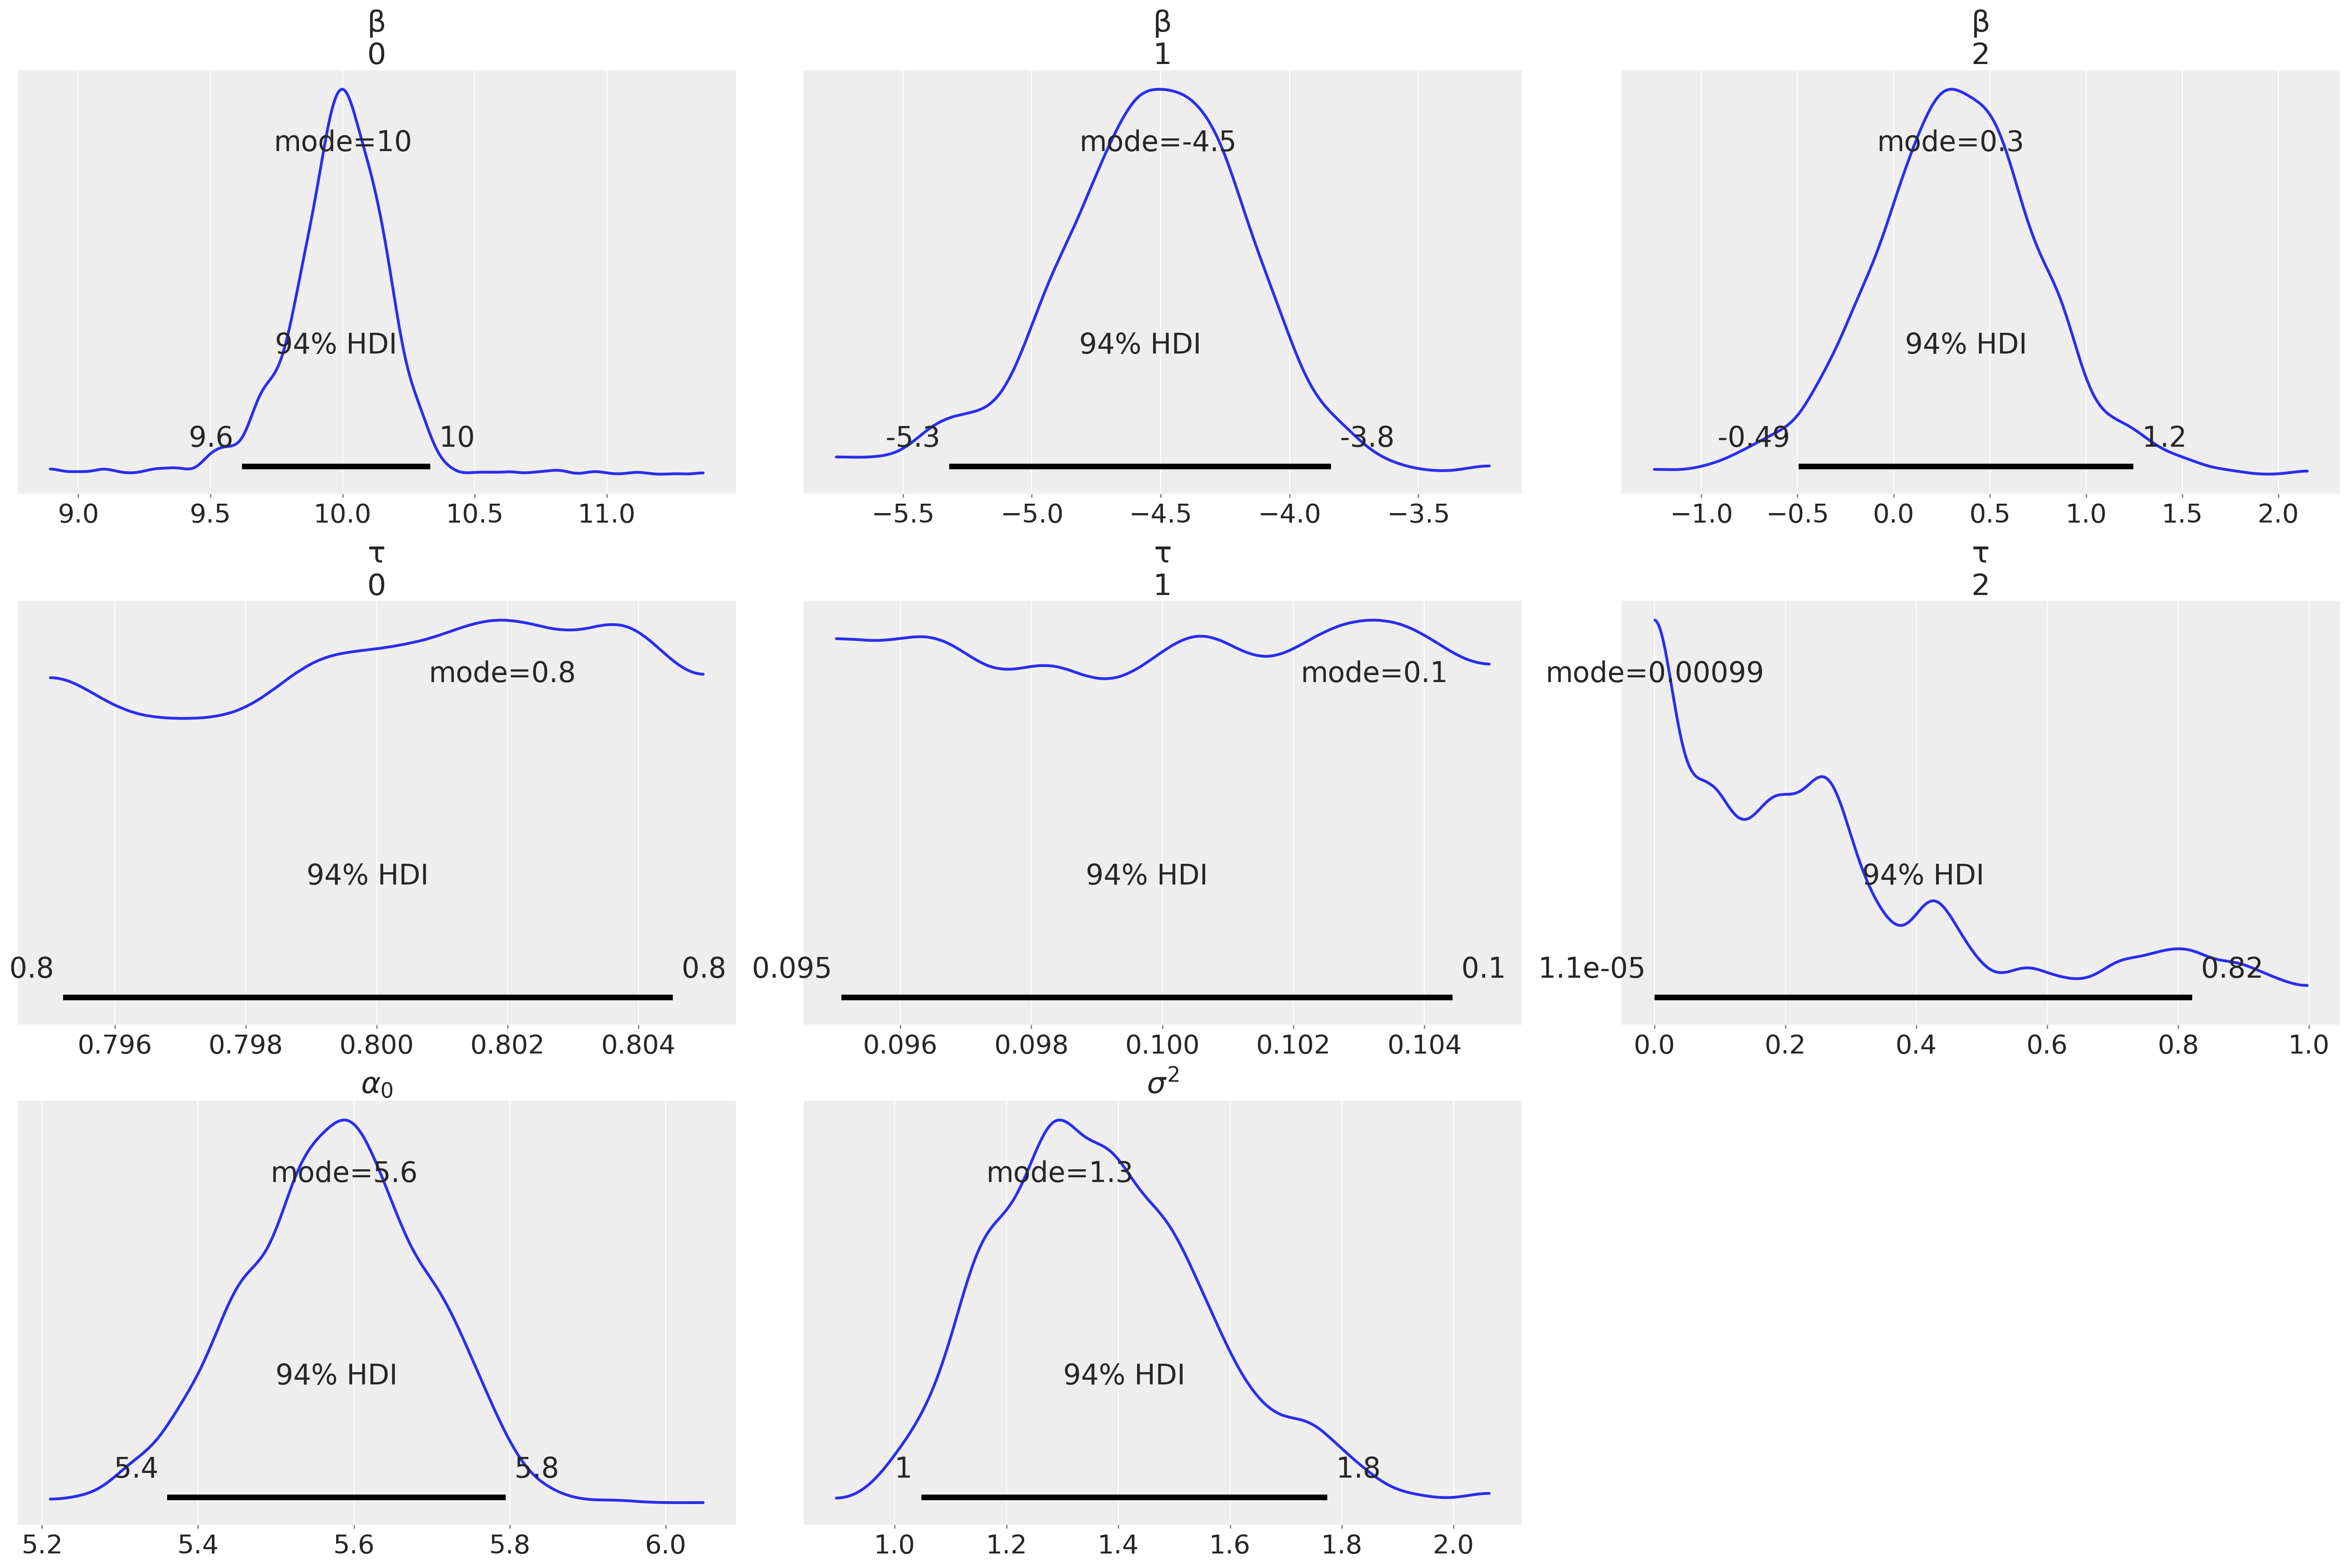

In [89]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


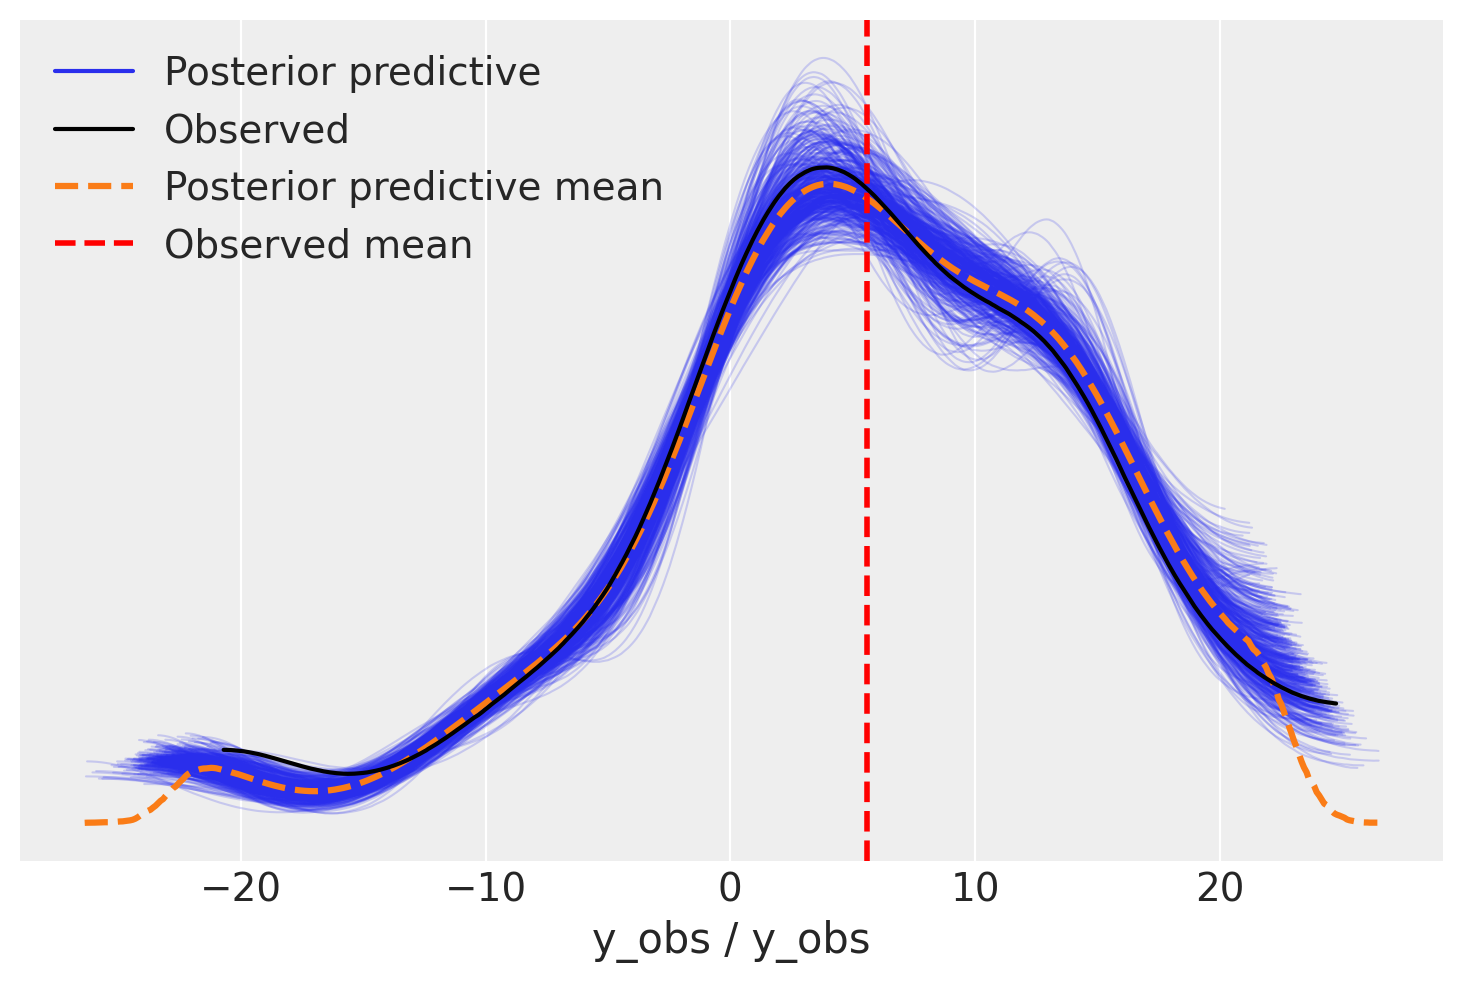

In [91]:
with model:
    print("Generating posterior predictive samples...")
    ppc = pm.sample_posterior_predictive(idata_pymc)

utils.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc, model=model),
    y_obs=Y, n_samples=500)

In [97]:
ppc['y_obs'].shape

(2000, 100)

In [93]:
 az.from_pymc3(posterior_predictive=ppc, model=model)

Inference data with groups:
	> posterior_predictive
	> observed_data

Combined autocorrelation times:


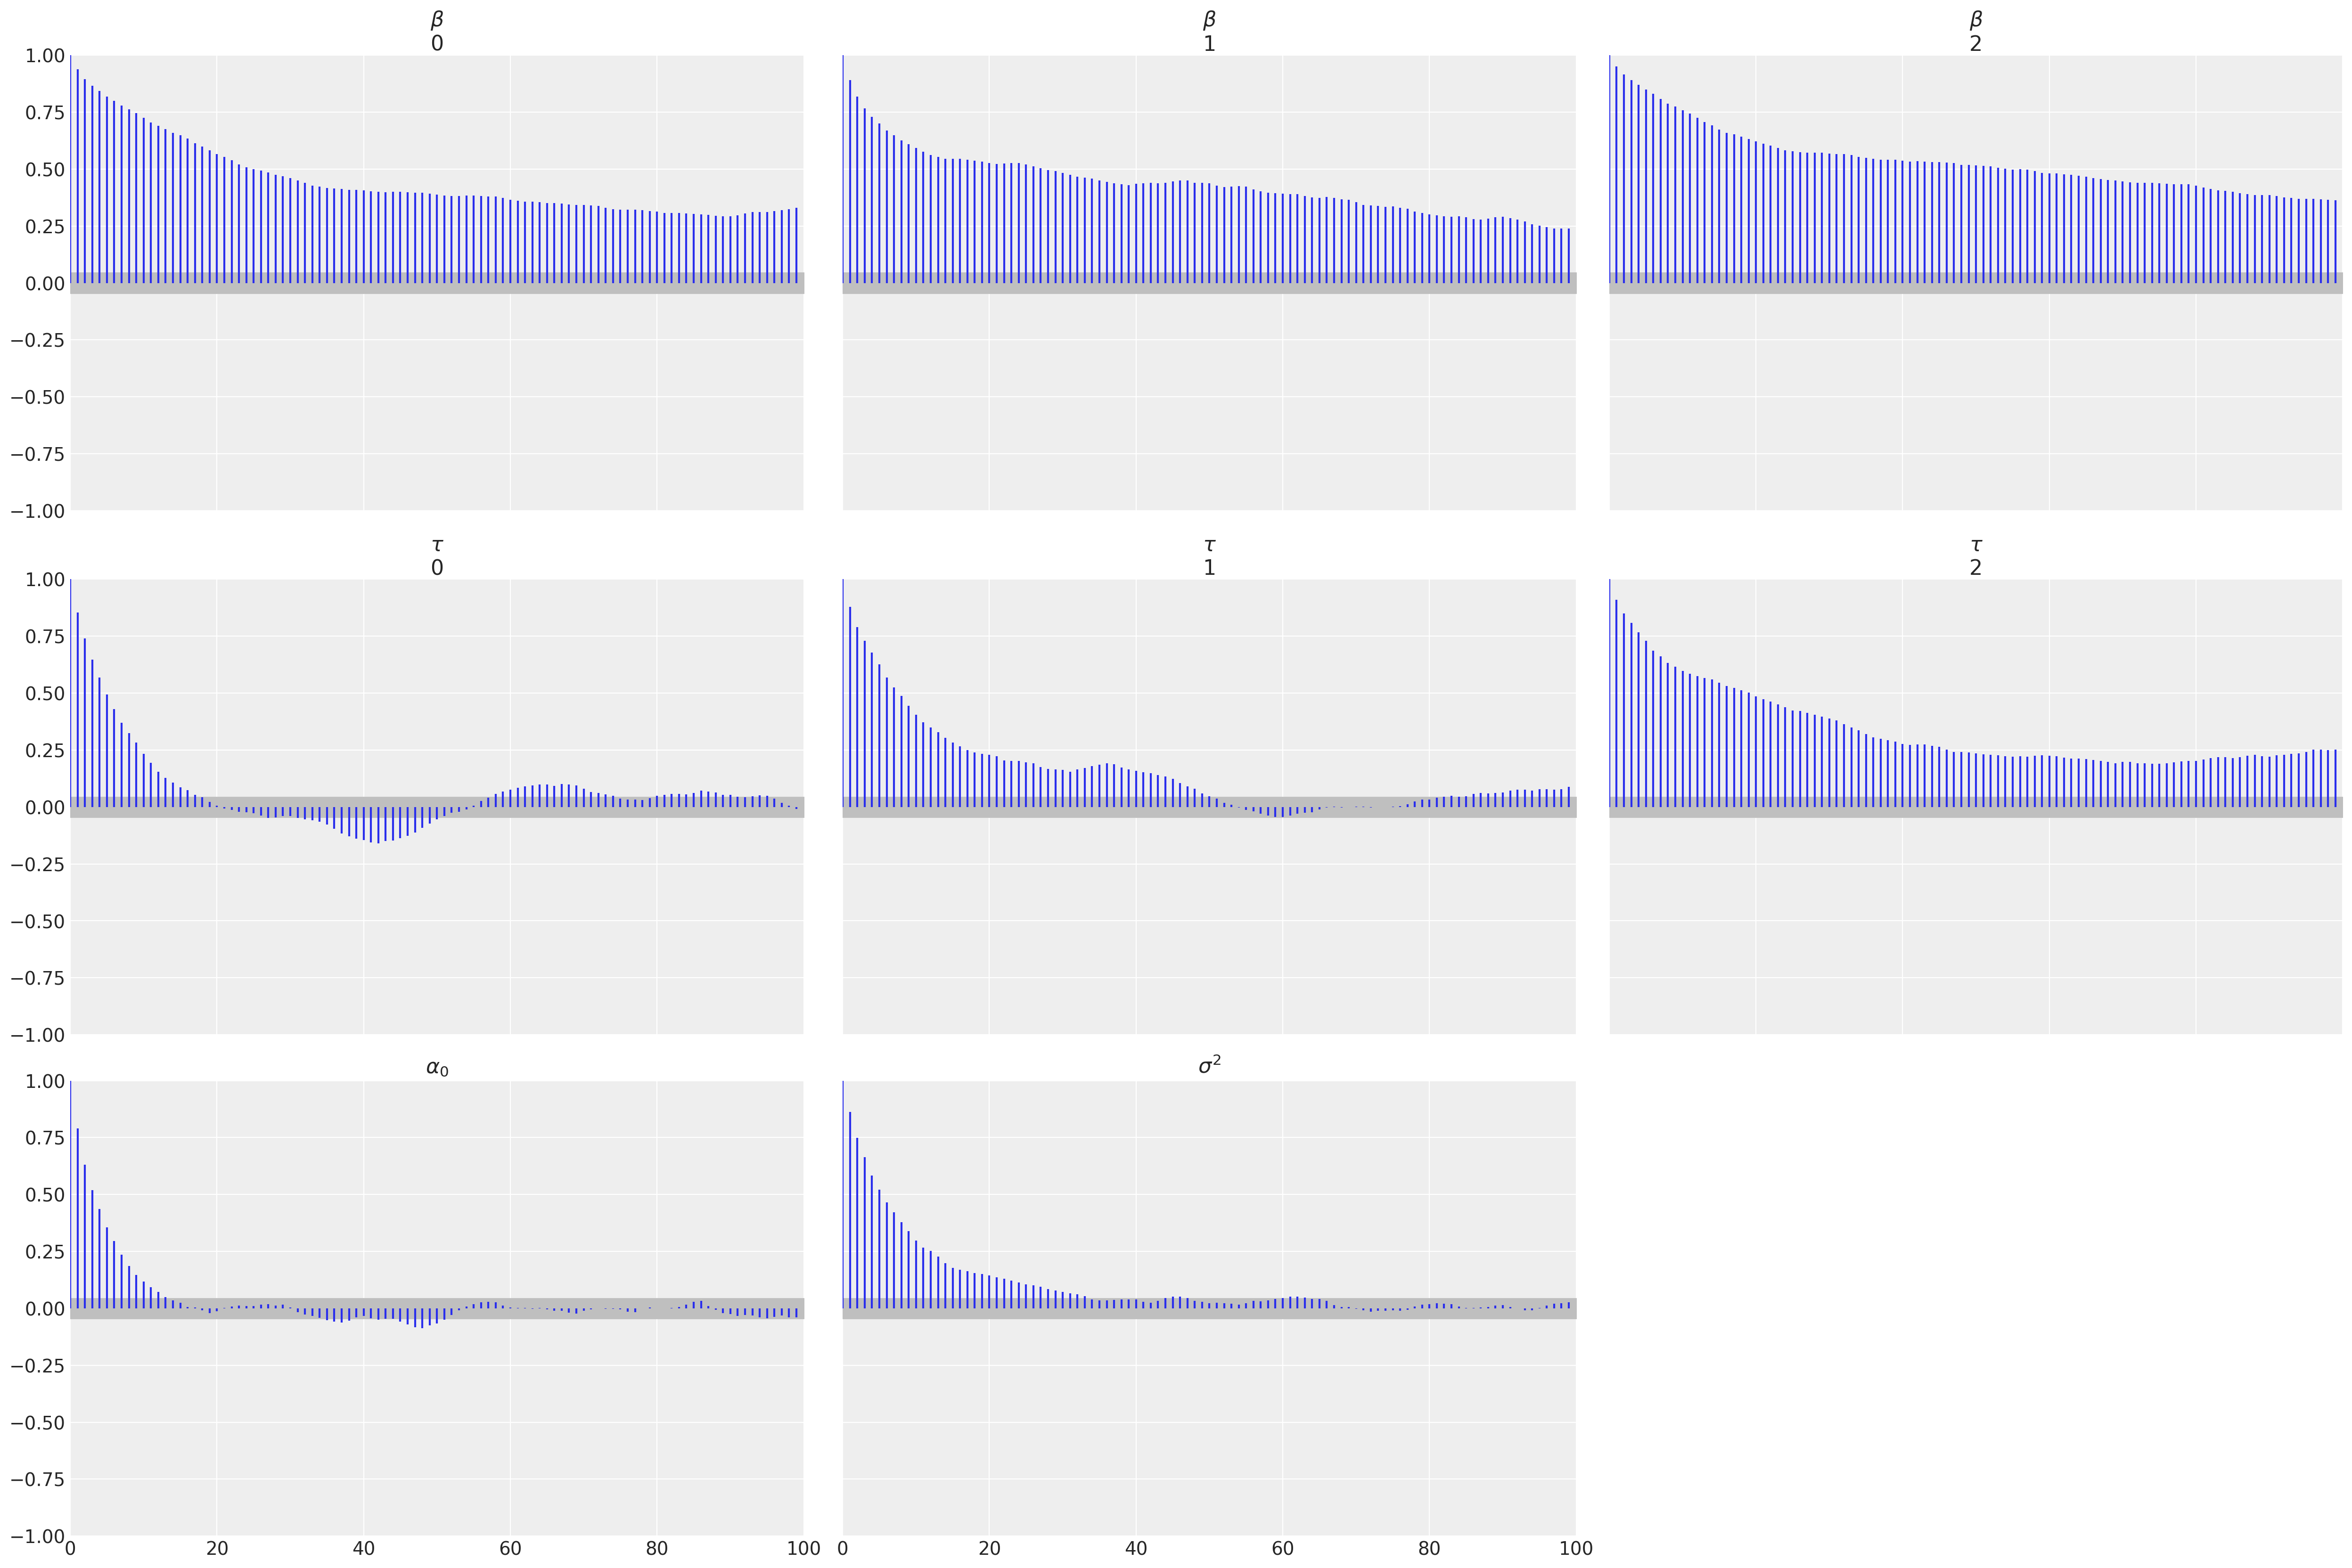

In [193]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


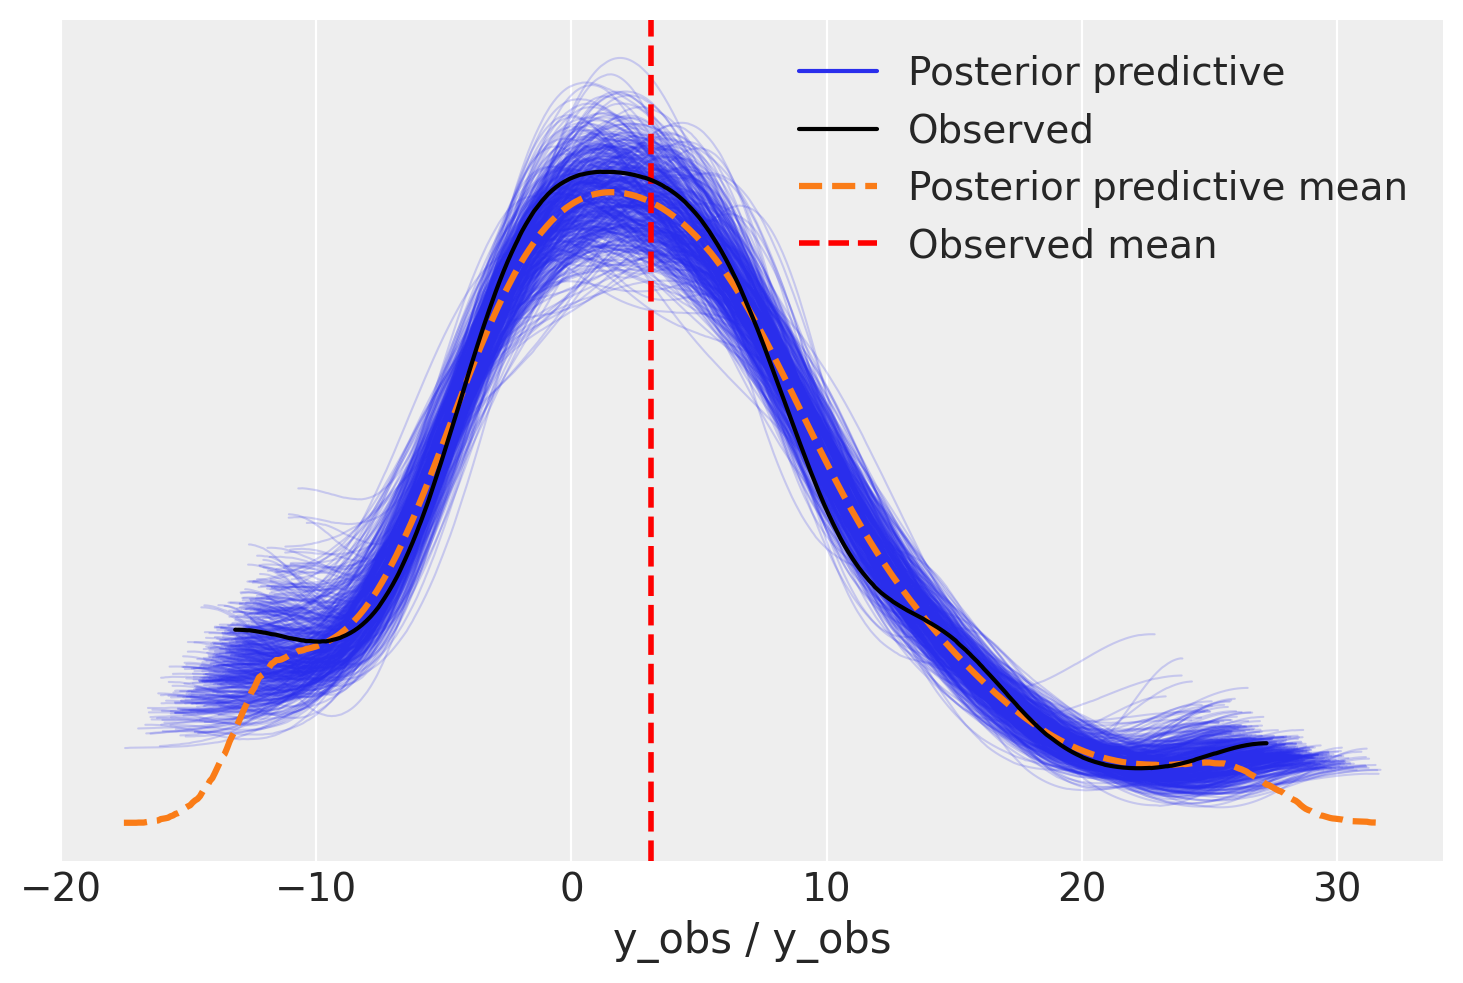

In [194]:
model_test = make_model(p_hat, g, eta, X_test, Y_test, grid)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    ppc_test = pm.sample_posterior_predictive(idata_pymc, var_names=["y_obs"])
    az.from_pymc3_predictions(
        predictions,
        idata_orig=idata_pymc3,
        inplace=True,
        coords={"candidate developer": candidate_devs},
        dims=dims_pred,
    )

utils.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc_test, model=model_test),
    y_obs=Y_test, n_samples=500)

Next we look at the MSE when using several point-estimates for the parameters.

In [102]:
point_estimates = ["mode", "mean", "median"]

df_mse_pymc = pd.DataFrame(columns=[""] + point_estimates)
df_mse_pymc.loc[0] = "MSE"

for pe in point_estimates:
    Y_hat = utils.point_predict(grid, X_test, idata_pymc,
                                theta_names, point_estimate=pe,
                                rng=rng)
    mse = utils.mse(Y_test, Y_hat)
    df_mse_pymc[pe] = [mse]

df_mse_pymc.style.hide_index()

NameError: name 'idata_pymc' is not defined

### Save & Load

In [32]:
_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [34]:
idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notes

### Utility functions

- `az.plot_pairs`
- `corner.corner`

### Alternative samplers in PyMC3

- `Metropolis` (+ MLE, MAP)
- `DeMetropolis(Z)`
- `Variational Inference in PyMC3`

### Alternative samplers in emcee

- Try different move proposals, or even a weighted mixture of moves.

### What's new in pymc v4

Some differences in the new release (see RELEASE-NOTES):

- Can pass distribution arguments (i.e RVs) to DensityDist. It has a new API.
- Model() accepts an `rng_seeder` argument to set the random seed.
- sample_posterior_predictive now returns an InferenceData object directly.
- shape vs ndim arguments in Distributions?

## Notebook metadata

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Oct 29 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

pandas    : 1.3.3
autopep8  : 1.5.7
emcee     : 3.1.1
json      : 2.0.9
matplotlib: 3.4.3
arviz     : 0.11.4
numpy     : 1.21.2
scipy     : 1.7.1

Watermark: 2.2.0

